In [3]:
import heapq
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import namedtuple
print(np.__version__)
import math

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

2.1.3
2.5.1+cu124


In [90]:
class Maze:
    """2D Gridworld Maze Game
    """

    State = namedtuple('State', ['x', 'y', 'steps_left', 'reward'])

    TARGET_REWARD = 300
    MOVE_REWARD = -1
    TIMEOUT_REWARD = -100

    def __init__(self, width: int, height: int, seed: Optional[int] = None, cell_occupancy_prob: float = 0.3):
        assert 0 < cell_occupancy_prob < 1, "Cell occupancy probability must be in the range (0, 1)"
        assert width > 2 and height > 2, "Width and height must be greater than 2"

        self.width = width
        self.height = height
        self.seed = seed
        self.cell_occupancy_prob = cell_occupancy_prob
        self.generate_map()

        # self.action_size = 5  # Up, Down, Left, Right, Stay
        self.action_size = 4

        self.max_steps=width*height

        self.observation_width = 5 # 5x5 observation window centered at the agent

    def get_initial_state(self) -> State:
        return Maze.State(self.source[0], self.source[1], self.max_steps, 0)
    
    def get_next_state(self, state: State, action):
        dx, dy = self.action_to_delta(action)
        # Additional reward is -1 for each x or y coordinate moved.
        dr = (abs(dx) + abs(dy)) * Maze.MOVE_REWARD
        if (state.x, state.y) == self.target:
            dr += Maze.TARGET_REWARD
        elif state.steps_left == 1:
            dr += Maze.TIMEOUT_REWARD
        return Maze.State(state.x + dx, state.y + dy, state.steps_left - 1, state.reward + dr)
    
    def get_encoded_observation(self, state: State):
        # Get the observation window centered at the agent
        # Assumes width is odd
        half_width = self.observation_width // 2

        # Pad the maze with obstacles (1s) to handle boundaries
        padded_maze = np.pad(self.map, pad_width=half_width, mode='constant', constant_values=1)

        # Adjust the agent's position due to padding
        x_padded = state.x + half_width
        y_padded = state.y + half_width

        # Plane 0: Obstacles
        # Extract the observation window where obstacle is 1 and free space is 0
        plane_obstacles = padded_maze[
            x_padded - half_width : x_padded + half_width + 1,
            y_padded - half_width : y_padded + half_width + 1
        ]

        # Make sure that any number that is not 1 is 0
        plane_obstacles[plane_obstacles != 1] = 0

        return np.stack([plane_obstacles], axis=0)

        # # Plane 1: Free Space (1s where free space, 0s where obstacles)
        # plane_free_space = plane_obstacles == 0

        # # Plane 2: Agent's position
        # plane_agent = np.zeros_like(plane_obstacles)
        # plane_agent[half_width, half_width] = 1

        # encoded_observation = np.stack([plane_obstacles, plane_free_space, plane_agent], axis=0)

        # return encoded_observation

    def get_valid_moves(self, state: State):
        valid_moves = []
        for action in range(self.action_size):
            dx, dy = self.action_to_delta(action)
            nx, ny = state.x + dx, state.y + dy
            if self.map[nx, ny] != 1:
                valid_moves.append(action)
        return valid_moves
    
    def get_value_and_terminated(self, state: State):
        min = Maze.TIMEOUT_REWARD + Maze.MOVE_REWARD * self.max_steps
        max = Maze.TARGET_REWARD

        normalized_value = (state.reward - min) / (max - min)
        if (state.x, state.y) == self.target or state.steps_left == 0:
            return normalized_value, True
    
        return normalized_value, False
    
    def action_to_delta(self, action):
        # action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0), (0, 0)]  # Down, Up, Left, Right, Stay
        action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0)] 
        return action_to_delta[action]
    
    def action_to_string(self, action):
        action_to_string = ['Down', 'Up', 'Left', 'Right', 'Stay']
        return action_to_string[action]
    
    def generate_map(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        count = 0
        while True:
            count += 1
            map = np.random.choice([0, 1], size=(self.width, self.height), p=[1-self.cell_occupancy_prob, self.cell_occupancy_prob])
            # Make the boundaries of the maze walls
            map[0, :] = 1
            map[-1, :] = 1
            map[:, 0] = 1
            map[:, -1] = 1

            # Randomly select two unique non-border positions for the source and target
            while True:
                # Generate two random positions within the non-border range
                source = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                target = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                
                # Ensure the positions are unique
                if source != target:
                    break
            
            # Make sure the source and target do not have obstacles
            map[source] = 2
            map[target] = 3

            self.source = source
            self.target = target

            # Set the max steps to be 3 * the L1 distance between source and target
            # self.max_steps = 3 * (abs(source[0] - target[0]) + abs(source[1] - target[1]))

            self.map = map
            astar = AStar(self)
            success, self.shortest_path = astar.solve()
            if success:
                break
            print(f"Unsolvable maze {count}. Regenerating...")

    def visualize_path(self, path=None):
        if path is None:
            path = self.shortest_path
        map = self.map.copy()
        truncated_path = path[1:-1]  # Exclude source and target
        for pos in truncated_path:
            map[pos] = 4
        self.visualize_state(map)

    def visualize_state(self, map: Optional[np.ndarray] = None):
        if map is None:
            map = self.map
        # Define colors for each type of cell
        cmap = mcolors.ListedColormap(['white', 'black', 'red', 'green', 'cyan'])
        
        # Plot the maze using imshow
        plt.imshow(map.T, cmap=cmap, vmin=0, vmax=4)
        # plt.axis('off')  # Hide axes
        plt.show()

class AStar:
    def __init__(self, maze: Maze):
        self.maze = maze
        self.start = maze.source
        self.goal = maze.target
        self.height, self.width = maze.height, maze.width

    def heuristic(self, a: Tuple[int, int], b: Tuple[int, int]) -> int:
        # Manhattan distance
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def successors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        successors = []
        directions = [(0, 1),(0, -1), (-1, 0), (1, 0)]  # Up, Down, Left, Right
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if self.maze.map[nx, ny] != 1:
                successors.append((nx, ny))
        return successors

    def solve(self) -> bool:
        open = []
        heapq.heappush(open, (0, self.start))
        came_from = {}
        g_score = {self.start: 0}

        while open:
            _, current = heapq.heappop(open)
            
            if current == self.goal:
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return True, path  # Maze is solvable

            for successor in self.successors(current):
                tentative_g_score = g_score[current] + 1
                if successor not in g_score or tentative_g_score < g_score[successor]:
                    came_from[successor] = current
                    g_score[successor] = tentative_g_score
                    f_score = tentative_g_score + self.heuristic(successor, self.goal)
                    heapq.heappush(open, (f_score, successor))

        return False, []  # Maze is not solvable

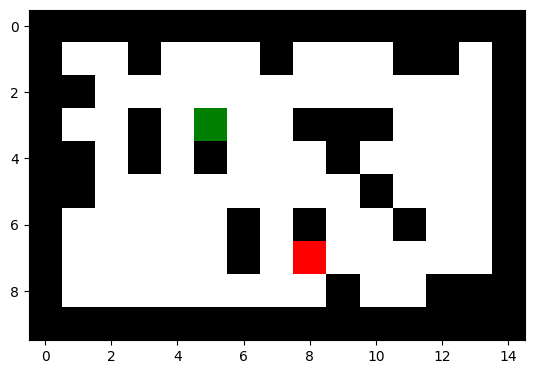

State(x=8, y=7, steps_left=150, reward=0)


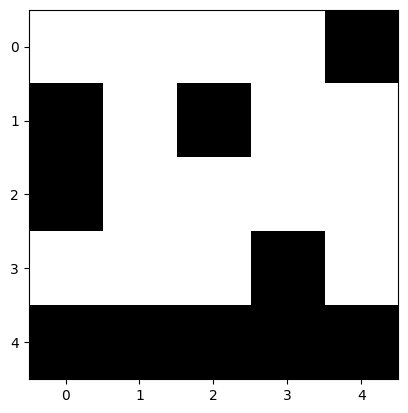

In [91]:
# Testing the observations
maze = Maze(15, 10)
maze.visualize_state()
print(maze.get_initial_state())
maze.visualize_state(map=maze.get_encoded_observation(maze.get_initial_state()))

In [139]:
class ResNet(nn.Module):
    def __init__(self, maze: Maze, num_resBlocks, num_filters):
        super().__init__()
        self.maze = maze

        # Initial convolutional block
        # The single input channel is for the observation where obstacles are 1 and free space is 0
        self.startBlock = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=num_filters),
            nn.ReLU()
        )

        # Residual blocks
        self.backBone = nn.ModuleList(
            [ResBlock(num_filters) for _ in range(num_resBlocks)]
        )

        # Policy head convolutional part that gets flattened
        self.policyHead_conv = nn.Sequential(
            nn.Conv2d(num_filters, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten()
        )

        # Compute the size after flattening
        policy_conv_output_size = 32 * maze.observation_width ** 2

        # Policy head fully connected part
        self.policyHead_flat = nn.Sequential(
            nn.Linear(policy_conv_output_size + 4, 256),  # Adding 4 for the positions of agent and target
            nn.ReLU(),
            nn.Linear(256, maze.action_size),
            nn.Softmax(dim=1)
        )

        # Value head convolutional part
        self.valueHead_conv = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten()
        )

        # Compute the size after flattening
        value_conv_output_size = 3 * maze.observation_width ** 2

        # Value head fully connected part
        self.valueHead_flat = nn.Sequential(
            nn.Linear(value_conv_output_size + 4, 256),  # Adding 4 for the positions
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid() # Value is between 0 and 1
        )

    def forward(self, x, agent_pos, goal_pos):
        # x: Input tensor of shape (batch_size, 3, maze_height, maze_width)
        # agent_pos and goal_pos: tensors of shape (batch_size, 2), not yet normalized

        # Normalize the positions
        maze_size = torch.tensor([self.maze.width, self.maze.height], dtype=torch.float32).to(agent_pos.device)
        agent_pos_norm = agent_pos / maze_size  # Shape: (batch_size, 2)
        goal_pos_norm = goal_pos / maze_size    # Shape: (batch_size, 2)

        # Initial convolutional block
        x = self.startBlock(x)

        # Residual blocks
        for resBlock in self.backBone:
            x = resBlock(x)

        # Policy head
        policy_x = self.policyHead_conv(x)  # Output is already flattened
        # Concatenate positions
        policy_x_concat = torch.cat([policy_x, agent_pos_norm, goal_pos_norm], dim=1)
        policy = self.policyHead_flat(policy_x_concat)

        # Value head
        value_x = self.valueHead_conv(x)  # Output is already flattened
        # Concatenate positions
        value_x_concat = torch.cat([value_x, agent_pos_norm, goal_pos_norm], dim=1)
        value = self.valueHead_flat(value_x_concat)

        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x


Unsolvable maze 1. Regenerating...


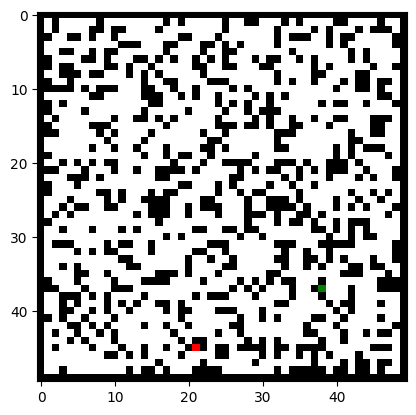

State(x=21, y=45, steps_left=2500, reward=0)


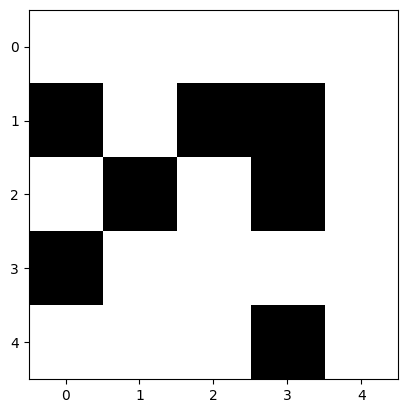

0.503173828125 [0.26578394 0.19801511 0.2510849  0.28511605]


/home/shaoyuan/Documents/Software/AlphaZeroFromScratch/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


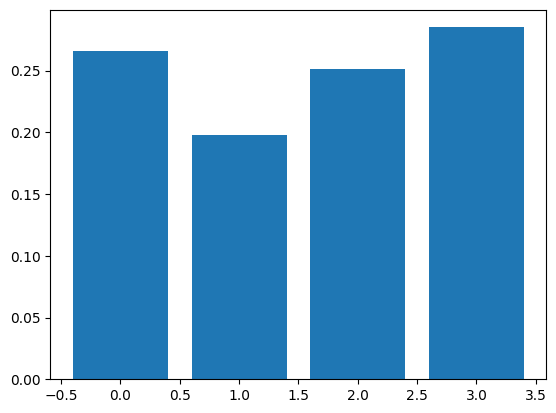

In [138]:
maze = Maze(50, 50)
state = maze.get_initial_state()
obs = maze.get_encoded_observation(state)
maze.visualize_state()
print(state)
maze.visualize_state(map=obs)

tensor_obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
tensor_agent_pos = torch.tensor([state.x, state.y], dtype=torch.float32).unsqueeze(0)
tensor_goal_pos = torch.tensor([maze.target[0], maze.target[1]], dtype=torch.float32).unsqueeze(0)

model = ResNet(maze, num_resBlocks=4, num_filters=64)

policy, value = model(tensor_obs, tensor_agent_pos, tensor_goal_pos)
value = value.item()
# policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()
policy = policy.squeeze(0).detach().cpu().numpy()

print(value, policy)

plt.bar(range(maze.action_size), policy)
plt.show()